### Imports

In [1]:
%reload_ext autoreload
%autoreload 2


import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd

import torch
import pytorch_lightning as pl
import wandb

import matplotlib.pyplot as plt

import scipy as sp
from scipy.ndimage.filters import gaussian_filter1d

from collections import Counter


import pytorch_lightning as pl
    
import allsim.infer as infer
import allsim.sim as sim
from allsim.policies.policy import MELD, MELD_na, FIFO
from allsim.outcome.counterfactual_inference import Inference_OrganITE
from allsim.outcome.counterfactual_models import OrganITE_Network

from data.data_module import UNOSDataModule, UKRegDataModule

import warnings
warnings.filterwarnings("ignore")

/tmp/ipykernel_286900/3320380174.py:20: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


### Data loading

In [2]:
data = 'UNOS'
data_dir = f'../data/{data}'

if data == 'UNOS':
    dm = UNOSDataModule(data_dir, batch_size=256)
    groups_r = [['DGRP_-1', 'DGRP_0', 'DGRP_1']]
    groups_x = [
        ['PATIENT_LOCATION_-1', 'PATIENT_LOCATION_0', 'PATIENT_LOCATION_1', 'PATIENT_LOCATION_2'],
        ['RAB_SURGERY_-1', 'RAB_SURGERY_0', 'RAB_SURGERY_1', 'RAB_SURGERY_2'],
        ['RASCITES_-1', 'RASCITES_0', 'RASCITES_1', 'RASCITES_2', 'RASCITES_3'],
        ['RENAL_SUPPORT_0', 'RENAL_SUPPORT_1', 'RENAL_SUPPORT_2'],
        ['RENCEPH_0', 'RENCEPH_1', 'RENCEPH_2', 'RENCEPH_3'],
        ['RHCV_-1', 'RHCV_0', 'RHCV_1', 'RHCV_2', 'RHCV_3'],
        ['RREN_SUP_-1', 'RREN_SUP_0', 'RREN_SUP_1'],
        ['SEX_0', 'SEX_1']
    ]


dm.prepare_data()
dm.setup(stage='fit')

DATA = pd.concat([dm._test_processed.copy(deep=True), dm._train_processed.copy(deep=True)])
DATA_true = DATA.copy(deep=True)
DATA_true[dm.real_cols] = dm.scaler.inverse_transform(
    DATA_true[dm.real_cols])

patients = DATA_true[dm.x_cols].copy(deep=True)
organs = DATA_true[dm.o_cols].copy(deep=True)

X = patients
O = organs
Y = dm._train_processed.Y


O_indices_in_real_cols = np.where(np.in1d(np.unique(dm.real_cols), O.columns.values))[0]
mean_real_cols_O = dm.scaler.mean_[O_indices_in_real_cols]
scale_real_cols_O = dm.scaler.scale_[O_indices_in_real_cols]
real_cols_indices_in_O = np.where(np.in1d(O.columns.values, np.unique(dm.real_cols)))[0]


X_indices_in_real_cols = np.where(np.in1d(np.unique(dm.real_cols), X.columns.values))[0]
mean_real_cols_X = dm.scaler.mean_[X_indices_in_real_cols]
scale_real_cols_X = dm.scaler.scale_[X_indices_in_real_cols]
real_cols_indices_in_X = np.where(np.in1d(X.columns.values, np.unique(dm.real_cols)))[0]




### Training Orgenite model

In [3]:
# OrganITE
input_dim = len(dm.o_cols) + len(dm.x_cols)
hidden_dim=16
num_hidden_layers=4
output_dim=6
lr=0.007
gamma=0.79
lambd=0.15
kappa=0.15
weight_decay=0.0006
n_clusters=15
activation_type="leaky_relu"
dropout_prob=0.11
epochs = 10

organite_model = OrganITE_Network(
             input_dim=input_dim,
             hidden_dim=hidden_dim,
             num_hidden_layers=num_hidden_layers,
             output_dim=output_dim,
             lr=lr,
             gamma=gamma,
             lambd=lambd,
             kappa=kappa,
             weight_decay=weight_decay,
             n_clusters=n_clusters,
             activation_type=activation_type,
             dropout_prob=dropout_prob,
).double()

organite_trainer = pl.Trainer(callbacks=[], max_epochs=epochs)
organite_trainer.fit(organite_model, datamodule=dm)

inference_oite = Inference_OrganITE(
    model=organite_model, mean=dm.mean, std=dm.std,
    x_indices_real=real_cols_indices_in_X, r_indices_real=real_cols_indices_in_O,
    x_mean=mean_real_cols_X, x_scale=scale_real_cols_X,
    r_mean=mean_real_cols_O, r_scale=scale_real_cols_O
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | representation | Sequential       | 2.0 K 
1 | propensity     | Sequential       | 147   
2 | output         | Sequential       | 49    
3 | loss_mse       | MeanSquaredError | 0     
4 | loss_cel       | CrossEntropyLoss | 0     
----------------------------------------------------
2.2 K     Trainable params
0         No

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Sense checking Organite inferences

In [4]:
for i in range(10):
    print(inference_oite.infer(
        np.random.rand(46).reshape(1, -1)
    ))

[[133405.08735191]]
[[133237.26114717]]
[[133430.31632029]]
[[133462.83250549]]
[[133215.42702135]]
[[133147.44632558]]
[[133452.95094316]]
[[133327.6607384]]
[[133372.77398502]]
[[133214.70617053]]


### Setting up simulation components

a) donor age

In [5]:
# RESOURCES
bins_r = [30, 45, 60]
def condition_function_r(age):
    i = np.where(np.in1d(dm.real_cols, 'DAGE'))[0]
    age=age
    return np.digitize(age, bins=bins_r).item()


condition_r = infer.Condition(
    labels=['DAGE'],
    function=condition_function_r,
    options=len(bins_r) + 1
)

kde_o = infer.KDEDensity(condition=condition_r, K=condition_r.options)
kde_o.fit(O[:15000], one_hot_encoded=groups_r)

b) recipient age

In [6]:
bins_x = [30, 45, 60]

def condition_function_x(bilir):
    return np.digitize(bilir, bins=bins_x).item()
    
condition_x = infer.Condition(
    labels=['RAGE'],
    function=condition_function_x,
    options=len(bins_x) + 1
)

kde_x = infer.KDEDensity(condition=condition_x, K=condition_x.options)
kde_x.fit(X[:15000], one_hot_encoded=groups_x)

### Combine into arrival process

In [7]:
resource_system, resource_system_steady, patient_system = dict(), dict(), dict()


def update_lam(t):
    if t < 600:
        return .5
    else:
        return .25


resource_system[0] = infer.PoissonProcess(update_lam=update_lam)
resource_system[1] = infer.PoissonProcess(update_lam=update_lam)
resource_system[2] = infer.PoissonProcess(update_lam=update_lam)
resource_system[3] = infer.PoissonProcess(update_lam=update_lam)


resource_system_steady[0] = infer.PoissonProcess(update_lam=lambda t: .5)
resource_system_steady[1] = infer.PoissonProcess(update_lam=lambda t: .5)
resource_system_steady[2] = infer.PoissonProcess(update_lam=lambda t: .5)
resource_system_steady[3] = infer.PoissonProcess(update_lam=lambda t: .5)


patient_system[3] = infer.PoissonProcess(update_lam=lambda t: 1)
patient_system[2] = infer.PoissonProcess(update_lam=lambda t: 1)
patient_system[1] = infer.PoissonProcess(update_lam=lambda t: 1)
patient_system[0] = infer.PoissonProcess(update_lam=lambda t: 1)

### Arrival plus density system

In [8]:
resource_process = infer.PoissonSystem(
    density=kde_o, 
    system=resource_system, 
    normalize=False)

resource_process_steady = infer.PoissonSystem(
    density=kde_o, 
    system=resource_system_steady, 
    normalize=False)

patient_process = infer.PoissonSystem(
    density=kde_x, 
    system=patient_system, 
    normalize=False)

### Define allocation policies

In [9]:
import copy

inference_oite.model.eval()

pl.seed_everything(123)
simulation = sim.Sim(
    resource_system=resource_process,
    patient_system=patient_process,
    inference=inference_oite
)

pl.seed_everything(123)
simulation_steady = sim.Sim(
    resource_system=resource_process_steady,
    patient_system=patient_process,
    inference=inference_oite
)

meld_na = MELD_na(name='MELD-Na', initial_waitlist=simulation._internal_waitlist, dm=dm)
meld_na_steady = MELD_na(name='MELD-Na', initial_waitlist=simulation_steady._internal_waitlist, dm=dm)


Seed set to 123
Seed set to 123


### Sampling the data

In [10]:
pl.seed_everything(123)
df_meld_na = simulation.simulate(meld_na, T=1021)

pl.seed_everything(123)
df_meld_na_steady = simulation_steady.simulate(meld_na_steady, T=1021)

Seed set to 123
100%|██████████| 1020/1020 [00:13<00:00, 75.73it/s]
Seed set to 123
100%|██████████| 1020/1020 [00:12<00:00, 79.11it/s]


### Plotting

Figure 3 from the paper: Two hypothetical scenarios. We require AllSim to evaluate a policy (e.g. MELD-Na) in hypothetical (counterfactual) scenarios. The x-axis is time, and the y-axis indicates survival time.

MELD-na avg days alive (318.0, 1010.4822618215519) (328.0, 1002.9365751704598) (338.0, 976.5667651184066) (348.0, 953.3832568511581) (358.0, 938.1931347029633) (368.0, 934.6087321796969) (378.0, 934.8311131256033) (388.0, 925.686606281931) (398.0, 895.8349029999193) (408.0, 883.3437545225189) (418.0, 855.2314793428884) (428.0, 833.1679430397852) (438.0, 808.4688373259335) (448.0, 791.9857358815772) (458.0, 800.6130446845582) (468.0, 791.4006397507592) (478.0, 791.738592200526) (488.0, 792.1496657863619) (498.0, 791.286453256949) (508.0, 800.717388070715) (518.0, 799.6498657844393) (530.0, 816.0861550976693) (541.0, 836.558691672502) (551.0, 841.0623858746789) (561.0, 851.6478601175716) (571.0, 841.0566059485042) (581.0, 834.2437973089257) (591.0, 836.1796654960882) (601.0, 824.8017905245867) (611.0, 801.3479968687998) (621.0, 769.3188970310713) (631.0, 739.402762676942) (641.0, 739.8225789069013) (651.0, 733.0462008889322) (661.0, 720.8943578935792) (671.0, 715.6188337394354) (684.0, 7

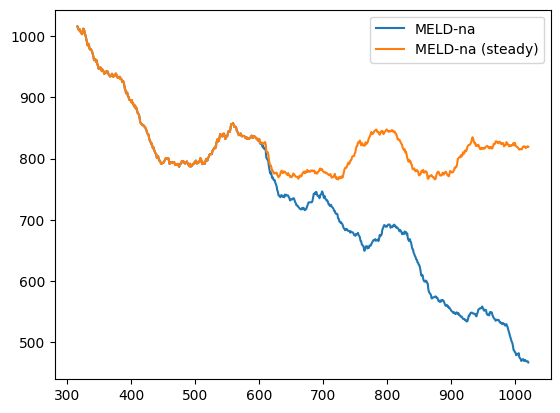

In [11]:
plt.plot(
    df_meld_na.t.unique(),
    df_meld_na.groupby('t').agg('mean').rolling(window=300).mean().ttl,
    label='MELD-na'
)

plt.plot(
    df_meld_na_steady.t.unique(),
    df_meld_na_steady.groupby('t').agg('mean').rolling(window=300).mean().ttl,
    label='MELD-na (steady)'
)


plt.legend()

window=300

print(
    'MELD-na avg days alive', 
    *list(zip(
        df_meld_na.t.unique()[np.arange(window, len(df_meld_na.t.unique()), 10)],
        df_meld_na.groupby('t').agg('mean').rolling(window=window).mean().ttl.to_numpy()[np.arange(window, len(df_meld_na.t.unique()), 10)])),
    sep=' '
)


print(
    'MELD-Na (steady) avg days alive', 
    *list(zip(
        df_meld_na_steady.t.unique()[np.arange(window, len(df_meld_na_steady.t.unique()), 10)], 
        df_meld_na_steady.groupby('t').agg('mean').rolling(window=window).mean().ttl.to_numpy()[np.arange(window, len(df_meld_na_steady.t.unique()), 10)])),
    sep=' '
)




### Redefine allocation policies and resource system

In [22]:
resource_system, patient_system = dict(), dict()

def update_lam_0(t):
    return (1 / (1+np.exp(-(t-450)/150))) * 3

def update_lam_1(t):
    return (1 / (1+np.exp((t-350)/150))) * 2

def update_lam_2(t):
    a = (1 / (1+np.exp((t-150)/150))) * 2
    b = (1 / (1+np.exp(-(t-650)/100))) * 2
    return (a + b)

def update_lam_3(t):
    a = (1 / (1+np.exp(-(t-150)/150)))
    b = (1 / (1+np.exp((t-650)/100)))
    return (a + b)


resource_system[0] = infer.PoissonProcess(update_lam=update_lam_0)
resource_system[1] = infer.PoissonProcess(update_lam=update_lam_1)
resource_system[2] = infer.PoissonProcess(update_lam=update_lam_2)
resource_system[3] = infer.PoissonProcess(update_lam=update_lam_3)

patient_system[3] = infer.PoissonProcess(update_lam=update_lam_0)
patient_system[2] = infer.PoissonProcess(update_lam=update_lam_1)
patient_system[1] = infer.PoissonProcess(update_lam=update_lam_2)
patient_system[0] = infer.PoissonProcess(update_lam=update_lam_3)

resource_process = infer.PoissonSystem(
    density=kde_o, 
    system=resource_system, 
    alpha=lambda t: 5, 
    normalize=True)

patient_process = infer.PoissonSystem(
    density=kde_x, 
    system=patient_system, 
    alpha=lambda t: 7, 
    normalize=True)

simulation = sim.Sim(
    resource_system=resource_process,
    patient_system=patient_process,
    inference=inference_oite
)

sim_meld = copy.deepcopy(simulation)
sim_meld_na = copy.deepcopy(simulation)
sim_fifo = copy.deepcopy(simulation)


meld = MELD(name='MELD', initial_waitlist=sim_meld._internal_waitlist, dm=dm)
meld_na = MELD_na(name='MELD-Na', initial_waitlist=sim_meld_na._internal_waitlist, dm=dm)
fifo = FIFO(name='FIFO', initial_waitlist=sim_fifo._internal_waitlist, dm=dm)

### Sampling the data for each policy

In [23]:
df_meld = sim_meld.simulate(meld, T=1021)
df_meld_na = sim_meld_na.simulate(meld_na, T=1021)
df_fifo = sim_fifo.simulate(fifo, T=1021)

100%|██████████| 1020/1020 [00:13<00:00, 75.59it/s]


### Plotting

**Figure 4 from the paper:**

Specifying a simulation using AllSim. In the above, a decision maker defines a set of donor arrival rates, based on age (λg and λK).

Using these very simple, but custom, arrival rates, we see a direct influence in the user and resource distributions (p(g) and p(K)).

These perturbations constitute as perturbations of type (iii) as per Sect. 2.4. Finally, the decision maker tries out three different policies: MELD, MELD-na, and FIFO, which constitute as perturbation type (i).

The result of these policies is shown on the right. The reported averages are windowed over 300 samples.

MELD avg days alive (301.0, 1205.017503639622) (311.0, 1210.8734571074556) (321.0, 1213.6362810086478) (331.0, 1211.7475731309723) (341.0, 1205.9898907908403) (351.0, 1191.952264778074) (361.0, 1193.0390950142166) (371.0, 1184.202131322166) (381.0, 1168.5743667124295) (391.0, 1163.8052485636908) (401.0, 1172.3125794771017) (411.0, 1173.0238712632981) (421.0, 1174.6104062904787) (431.0, 1162.5661434708452) (441.0, 1147.8623000413654) (452.0, 1139.4311536035002) (462.0, 1148.8232377633574) (472.0, 1155.415188361566) (482.0, 1151.7207620673464) (492.0, 1138.3318343405297) (502.0, 1125.3913471368023) (512.0, 1129.0711113665834) (522.0, 1116.4799339955453) (532.0, 1106.9304754077966) (542.0, 1117.8296502098456) (552.0, 1124.7502338442791) (562.0, 1132.8695838386266) (572.0, 1135.2844117710251) (582.0, 1124.893855976008) (592.0, 1119.8563379893276) (602.0, 1118.1337027340917) (612.0, 1107.026015281321) (622.0, 1097.5911090791137) (632.0, 1081.413303917744) (642.0, 1071.592094322662) (652.0, 

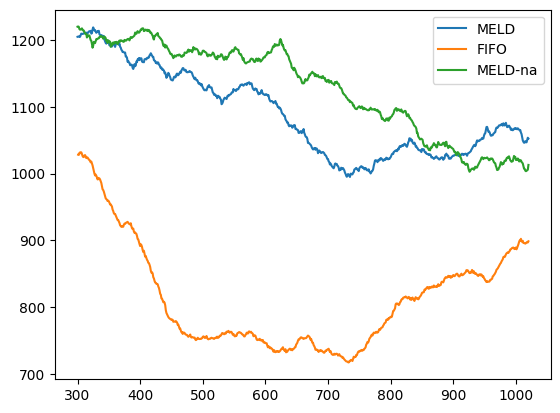

In [24]:
plt.plot(
    df_meld.t.unique(),
    df_meld.groupby('t').agg('mean').rolling(window=300).mean().ttl,
    label='MELD'
)

plt.plot(
    df_fifo.t.unique(),
    df_fifo.groupby('t').agg('mean').rolling(window=300).mean().ttl,
    label='FIFO'
)

plt.plot(
    df_meld_na.t.unique(),
    df_meld_na.groupby('t').agg('mean').rolling(window=300).mean().ttl,
    label='MELD-na'
)

plt.legend()

window=300

print(
    'MELD avg days alive', 
    *list(zip(
        df_meld.t.unique()[np.arange(window, 989, 10)], 
        df_meld.groupby('t').agg('mean').rolling(window=window).mean().ttl.to_numpy()[np.arange(window, 989, 10)])),
    sep=' '
)


print(
    'MELD-Na avg days alive', 
    *list(zip(
        df_meld_na.t.unique()[np.arange(window, 989, 10)], 
        df_meld_na.groupby('t').agg('mean').rolling(window=window).mean().ttl.to_numpy()[np.arange(window, 989, 10)])),
    sep=' '
)


print(
    'FIFO avg days alive', 
    *list(zip(
        df_fifo.t.unique()[np.arange(window, 989, 10)], 
        df_fifo.groupby('t').agg('mean').rolling(window=window).mean().ttl.to_numpy()[np.arange(window, 989, 10)])),
    sep=' '
)


DAGE (305.0, 49.10055296734047) (315.0, 49.06381525943161) (325.0, 48.85737852110573) (335.0, 48.76560178484317) (345.0, 48.79376206404924) (355.0, 48.87010495016267) (365.0, 48.74900504213836) (375.0, 48.748176635827406) (385.0, 48.56879205749909) (395.0, 48.60197729020908) (405.0, 48.60588256689453) (415.0, 48.48835147469334) (425.0, 48.26265797644125) (435.0, 48.09493390476365) (445.0, 48.003995745981136) (456.0, 47.7737231721857) (467.0, 47.8991334068338) (477.0, 47.84106982351024) (487.0, 47.68441195740919) (497.0, 47.54111136247359) (507.0, 47.15942824223695) (517.0, 46.89230351014605) (527.0, 46.86530087502803) (537.0, 46.784275963619976) (547.0, 46.769885198379924) (557.0, 46.73476630523632) (567.0, 46.46965635723215) (577.0, 46.09681097905381) (587.0, 45.992754185913114) (597.0, 46.143039180934466) (607.0, 45.98709801697361) (617.0, 45.67823186360707) (627.0, 45.43982741955321) (637.0, 44.947854325742675) (647.0, 44.79104820184977) (657.0, 44.5142132236209) (667.0, 44.31553200

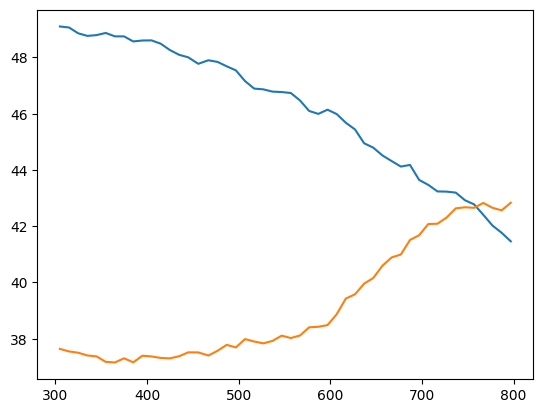

In [25]:
window = 300
donor_df = df_meld[df_meld.DAGE.notna()]

plt.plot(
    donor_df.t.unique()[np.arange(window, 796, 10)],
    donor_df.groupby('t').agg('mean').rolling(window=window).mean().DAGE.to_numpy()[np.arange(window, 796, 10)]
)



plt.plot(
    donor_df.t.unique()[np.arange(window, 796, 10)],
    donor_df.groupby('t').agg('mean').rolling(window=window).mean().RAGE.to_numpy()[np.arange(window, 796, 10)]
)


print(
    'DAGE', 
    *list(zip(
        donor_df.t.unique()[np.arange(window, 796, 10)], 
        donor_df.groupby('t').agg('mean').rolling(window=window).mean().DAGE.to_numpy()[np.arange(window, 796, 10)])),
    sep=' '
)


print(
    'RAGE', 
    *list(zip(
        donor_df.t.unique()[np.arange(window, 796, 10)], 
        donor_df.groupby('t').agg('mean').rolling(window=window).mean().RAGE.to_numpy()[np.arange(window, 796, 10)])),
    sep=' '
)


0 (300, 0.8068242641099853) (310, 0.84674682912678) (320, 0.8878451171485127) (330, 0.9300765566171627) (340, 0.9733910310316374) (350, 1.0177308937025484) (360, 1.0630310813226136) (370, 1.109219331246746) (380, 1.1562165051973516) (390, 1.203937019662644) (400, 1.252289380613056) (410, 1.3011768174136824) (420, 1.3504980080625666) (430, 1.400147885246606) (440, 1.4500185102917658) (450, 1.5) (460, 1.5499814897082342) (470, 1.5998521147533942) (480, 1.6495019919374339) (490, 1.6988231825863176) (500, 1.747710619386944) (510, 1.796062980337356) (520, 1.8437834948026486) (530, 1.890780668753254) (540, 1.9369689186773862) (550, 1.9822691062974518) (560, 2.026608968968363) (570, 2.0699234433828373) (580, 2.1121548828514873) (590, 2.15325317087322) (600, 2.193175735890015) (610, 2.2318874739742744) (620, 2.269360587691213) (630, 2.3055743504970527) (640, 2.3405148067779526) (650, 2.374174418021865) (660, 2.406551665675745) (670, 2.437650621012776) (680, 2.4674804918637787) (690, 2.49605515

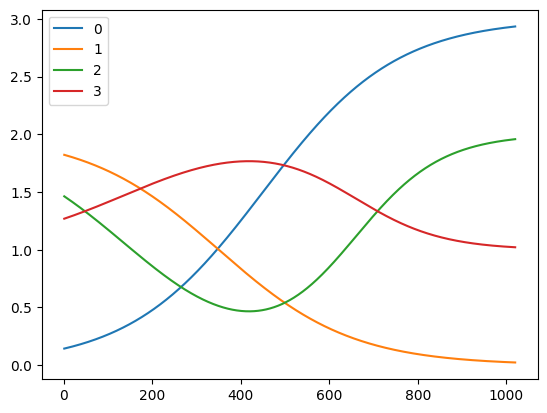

In [26]:
for c in resource_system.keys():
    plt.plot(
        donor_df.t,
        [resource_system[c].update_lam(t) for t in donor_df.t], label=c)
    
    print(
        c, 
        *list(zip(
            np.arange(window, 1020, 10), 
            [resource_system[c].update_lam(t) for t in np.arange(window, 1020, 10)])),
        sep=' '
    )
    print('\n\n')
    
plt.legend()